# training samples:60000
# testing samples:10000
image size: (28, 28)
features per sample: 784


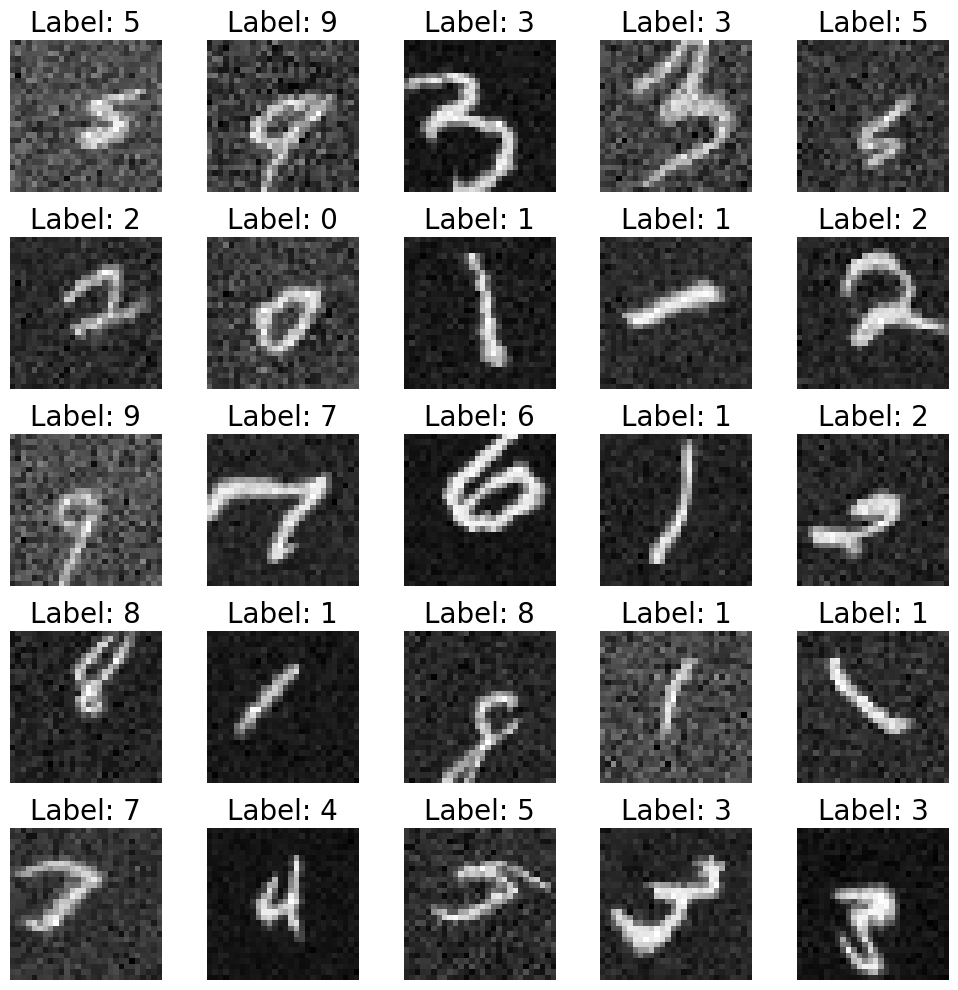

In [1]:
import numpy as np
import random
import torchvision
import torch
import matplotlib.pyplot as plt
import math
from PIL import Image

from torchvision import transforms

# prepare preprocessing of data

class AddRandomNoise(object):
    def __init__(self, mean=0.0, std1=0.1, std2=0.3):
        self.mean = mean
        self.std1 = std1  # Lower bound of the standard deviation range
        self.std2 = std2  # Upper bound of the standard deviation range

    def __call__(self, tensor):
        # U-shaped distribution for the standard deviation of the noise
        if random.random() < 0.5:
            actual_std = np.abs(np.random.normal(self.std1, self.std1 / 2))
        else:
            actual_std = np.abs(np.random.normal(self.std2, self.std2 / 2))
        
        # Clip the standard deviation to be within 0 and the maximum desired standard deviation
        actual_std = np.clip(actual_std, 0, self.std2)

        noise = torch.randn(tensor.size()) * actual_std + self.mean
        return tensor + noise

transform_steps = transforms.Compose([
	transforms.RandomRotation(40, fill=0),
	transforms.RandomPerspective(fill=0),
	transforms.ElasticTransform(alpha=80.0),
	transforms.RandomAffine(0, (0.1,0.1), fill=0),
	transforms.RandomResizedCrop((28), scale=(1.0, 1.5)),
	transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,)),
	AddRandomNoise(),
])

batch_size = 25

train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_steps)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_steps)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

i = random.randint(0, len(test_data) - 1)
random_sample_img, random_sample_label = test_data[i]

# show the number of rows and columns
print( "# training samples:" + str(len(train_data)) )
print( "# testing samples:" + str(len(test_data)) )
# print( "cols (# features):" + str(random_sample_img.numel()) )
print(f"image size: ({random_sample_img.shape[1]}, {random_sample_img.shape[2]})")
print("features per sample:", random_sample_img.flatten().shape[0])

def show_images(images, labels, predictions=None):
	num_cols = 5
	num_rows = math.ceil(len(images) / num_cols)
	fig = plt.figure(figsize=(10, 2 * num_rows))
	for i in range(len(images)):
		ax = fig.add_subplot(num_rows, num_cols, i+1, xticks=[], yticks=[])
		if predictions is not None:
			color = "green" if predictions[i] == labels[i] else "red"
			ax.set_title(f"Label: {labels[i]}\nPred: {predictions[i]}", fontsize=20, color=color)
		else:
			ax.set_title(f"Label: {labels[i]}", fontsize=20)
		ax.axis('off')
		
		image = images[i]
		if isinstance(image, Image.Image):
			ax.imshow(image, cmap='gray')
		else:
			ax.imshow(image.squeeze().numpy(), cmap='gray')
	plt.tight_layout()
	plt.show()

example_images, example_labels = next(iter(testloader))

show_images(example_images, example_labels)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

learning_rate = 1e-4
learning_rate_warmup_ratio = 0.1
learning_rate_decay = 0.5
learning_rate_step_size = 2400
weight_decay = 0.01
dropout = 0.3

print("Is cuda available?", torch.cuda.is_available())

model = nn.Sequential(
    # input shape: 1 x 28 x 28 = 784
	
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
	# outputs 32 feature maps with the same size as the original image
	# shape: 32 x 28 x 28 = 25088
	
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
	# outputs 32 feature maps with half the size of the original image
	# shape: 32 x 14 x 14 = 6272
	
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
	# outputs 64 feature maps with the same size as the previous feature maps
	# shape: 64 x 14 x 14 = 12544
	
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
	# outputs 64 feature maps with half the size of the previous feature maps
    # output size: 64 x 7 x 7 = 3136

    nn.Flatten(),

    nn.Linear(64 * 7 * 7, 1000),
    nn.ReLU(),
    nn.Dropout(p=dropout),

    nn.Linear(1000, 128),
    nn.ReLU(),
    nn.Dropout(p=dropout),
    nn.Linear(128, 10),
)

optimizer = optim.Adam(
    model.parameters(), 
    lr=learning_rate,
    weight_decay=weight_decay,
)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=learning_rate_step_size, gamma=learning_rate_decay)

loss_function = nn.CrossEntropyLoss()

print(model)


Is cuda available? True
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=1000, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.3, inplace=False)
  (10): Linear(in_features=1000, out_features=128, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.3, inplace=False)
  (13): Linear(in_features=128, out_features=10, bias=True)
)


In [3]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
print("Using GPU with CUDA" if device_name == "cuda" else "Using CPU")
device = torch.device(device_name)

model.to(device)
loss_function.to(device)

epochs = 3
eval_batch_interval = 600

num_batches = len(trainloader)

for epoch in range(epochs):
	training_losses = []
	model.train()
	for batch_index, (data, target) in enumerate(trainloader):
		data, target = data.to(device), target.to(device)
		optimizer.zero_grad()
		output = model(data)
		loss = loss_function(output, target)
		loss.backward()
		optimizer.step()
		scheduler.step()
		training_losses.append(loss.item())
		
		if batch_index % eval_batch_interval == 0:
			model.eval()
			test_losses = []
			with torch.no_grad():
				correct = 0
				total = 0
				for inputs, labels in testloader:
					inputs = inputs.to(device)
					labels = labels.to(device)

					outputs = model(inputs)
					_, predicted = torch.max(outputs, 1)
					total += labels.size(0)
					correct += (predicted == labels).sum().item()
					test_losses.append(loss_function(outputs, labels).item())
			
			print("|".join([
				f"Epoch {epoch + 1}/{epochs}".center(12),
				f"Learning Rate {scheduler.get_last_lr()[0]:.2e}".center(25),
				f"Batch {batch_index}/{num_batches}".center(25),
				f"Sample {batch_index * batch_size}/{num_batches * batch_size}".center(25),
				f"Training Loss: {format(np.mean(training_losses), '.5f')}".center(30),
				f"Validation Loss: {format(np.mean(test_losses), '.5f')}".center(30),
				f"Accuracy: {format(100 * correct / total, '.2f')}% {correct}/{total}".center(35),
			]))

print("Finished training")

Using GPU with CUDA


 Epoch 1/3  |  Learning Rate 1.00e-04 |       Batch 0/2400      |      Sample 0/60000     |    Training Loss: 2.31417    |   Validation Loss: 2.30215   |    Accuracy: 10.44% 1044/10000    
 Epoch 1/3  |  Learning Rate 1.00e-04 |      Batch 600/2400     |    Sample 15000/60000   |    Training Loss: 2.04906    |   Validation Loss: 1.73864   |    Accuracy: 42.88% 4288/10000    
 Epoch 1/3  |  Learning Rate 1.00e-04 |     Batch 1200/2400     |    Sample 30000/60000   |    Training Loss: 1.78280    |   Validation Loss: 1.37818   |    Accuracy: 55.65% 5565/10000    
 Epoch 1/3  |  Learning Rate 1.00e-04 |     Batch 1800/2400     |    Sample 45000/60000   |    Training Loss: 1.61691    |   Validation Loss: 1.18616   |    Accuracy: 60.64% 6064/10000    
 Epoch 2/3  |  Learning Rate 5.00e-05 |       Batch 0/2400      |      Sample 0/60000     |    Training Loss: 1.21052    |   Validation Loss: 1.02445   |    Accuracy: 66.62% 6662/10000    
 Epoch 2/3  |  Learning Rate 5.00e-05 |      Batch 600/

Using GPU with CUDA


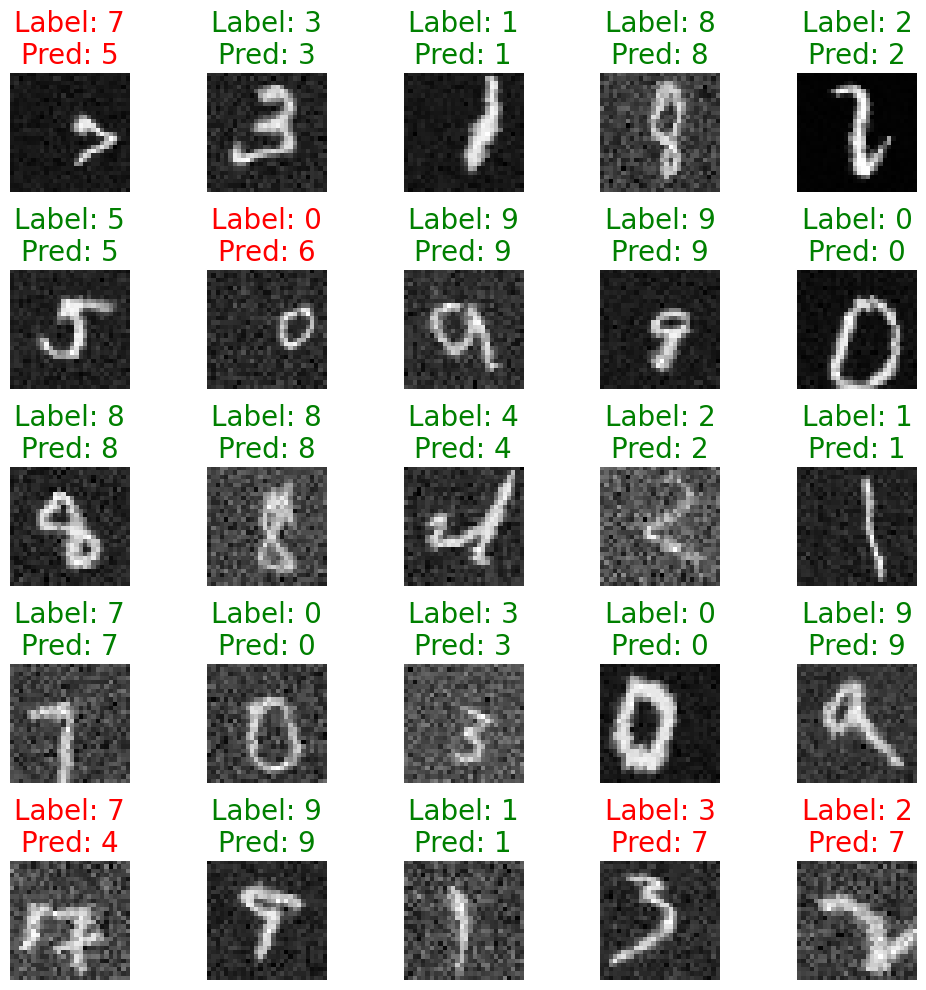

In [4]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
print("Using GPU with CUDA" if device_name == "cuda" else "Using CPU")
device = torch.device(device_name)

# show some predictions
model.eval()
images, labels = next(iter(testloader))
images = images.to(device)
labels = labels.to(device)
outputs = model(images)
_, predictions = torch.max(outputs, 1)
show_images(images.cpu(), labels.cpu(), predictions.cpu())


In [5]:
# save the model
torch.save(model.state_dict(), "model.pth")